In [34]:
import os
import sys
sys.path.append(os.path.expanduser("~"))
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D
from utils import draw_figure,compute_pk, plot_residual
from UNet_apply import applyCNN, applyCNN_TF
import comet_ml
import torch
from torch import nn
from torch.nn.functional import mse_loss, l1_loss
from torch import autograd, Tensor
from lightning.pytorch import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from typing import Optional, Tuple
from torch.special import expm1
from tqdm import trange
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
import Pk_library as PKL

device = torch.device("cuda") if torch.cuda.is_available() else "mps"
print(device)
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('custom', colors)

vmin = -2.0
vmax = 2.0


cuda


In [98]:
import importlib
import UNet_apply
import camel_dataloader
importlib.reload(UNet_apply) 
importlib.reload(camel_dataloader) 
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D

from UNet_apply import applyCNN, applyCNN_TF

[rank: 0] Seed set to 7


cuda


In [2]:
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'

dm_TF = get_astro_data_2D_from_3D(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size)

In [26]:
dm_25_thick = get_astro_data(
        dataset,
        num_workers=num_workers,
        # resize=cropsize,
        batch_size=batch_size,
    )
path = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/5ef90d60aaca4012837cd4275273e171/checkpoints/latest-epoch=9-step=1750.ckpt'

In [99]:
conditioning, params, target = dm_25_thick.test_data[100]

In [100]:
residual_grid, postTF_grid = applyCNN(conditioning[np.newaxis,:], cond=True, params = params[np.newaxis,:]) #path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere

suite: Astrid


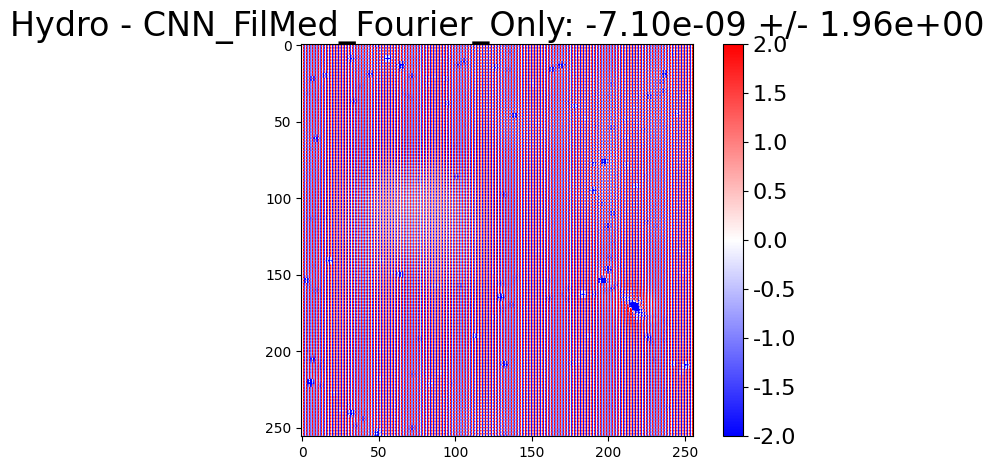

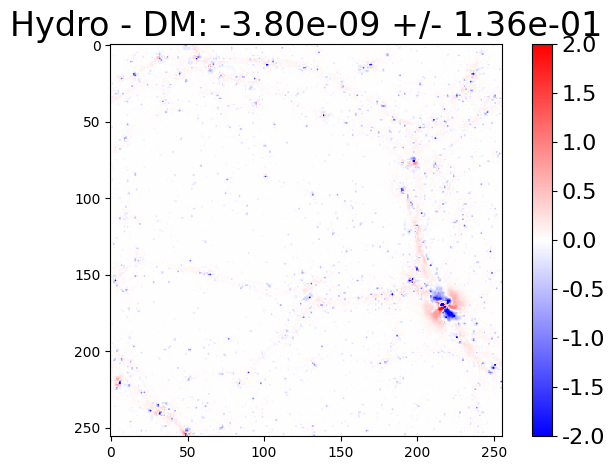

In [101]:
diff = residual_grid.detach().numpy()
im = plt.imshow(diff, cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=16)
plt.title(f'Hydro - CNN_FilMed_Fourier_Only: {diff.mean():.2e} +/- {diff.std():.2e}', fontsize=24)
plt.tight_layout()
plt.show()

true = target.detach().numpy().reshape([256,256])
im = plt.imshow(true, cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=16)
plt.title(f'Hydro - DM: {true.mean():.2e} +/- {true.std():.2e}', fontsize=24)
plt.tight_layout()
plt.show()

suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds


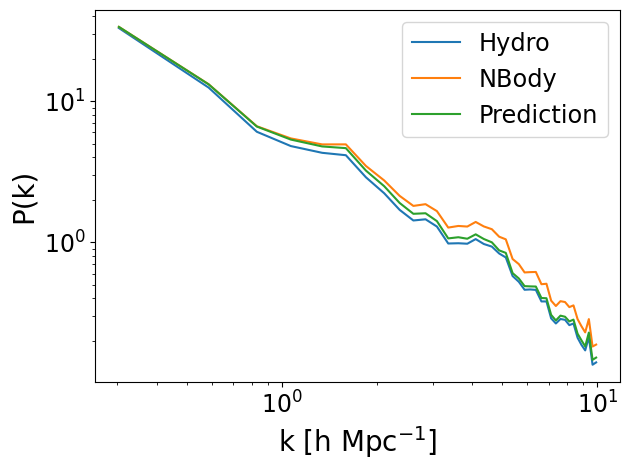

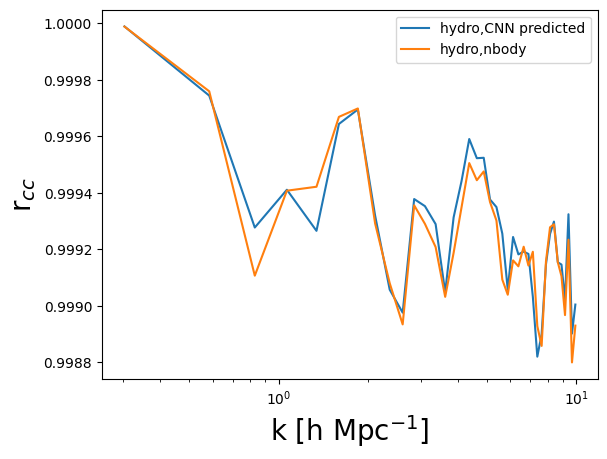

/tmp/ipykernel_315494/2503159644.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='large')


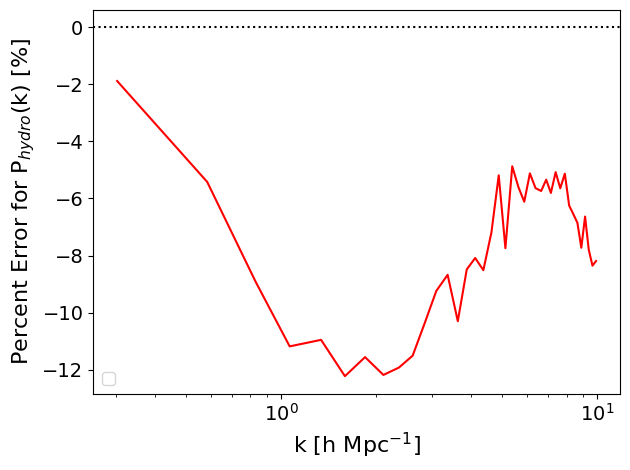

suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


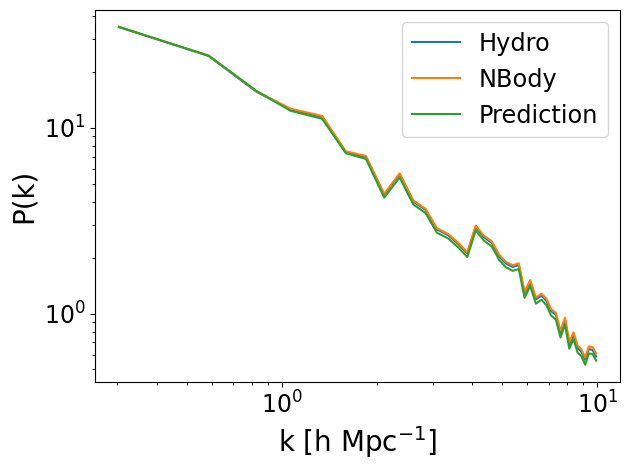

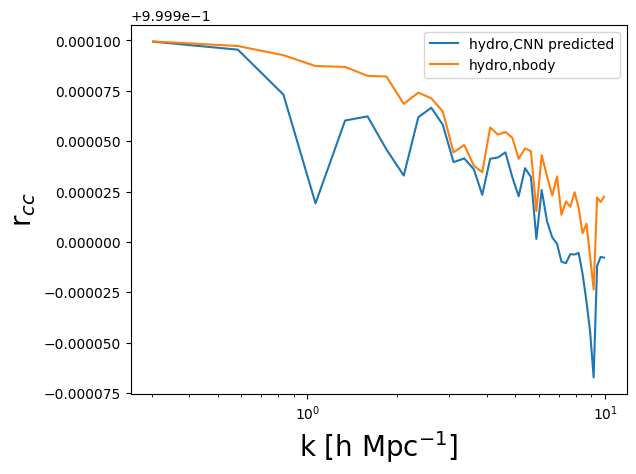

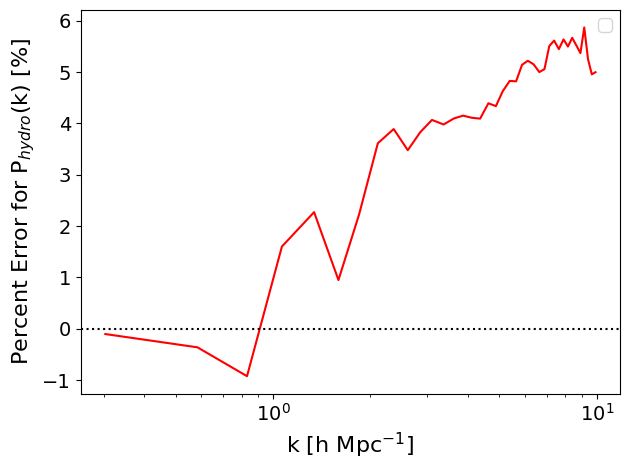

suite: Astrid

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


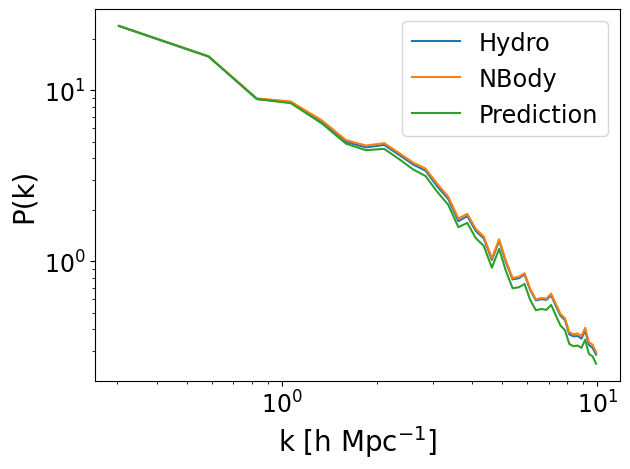

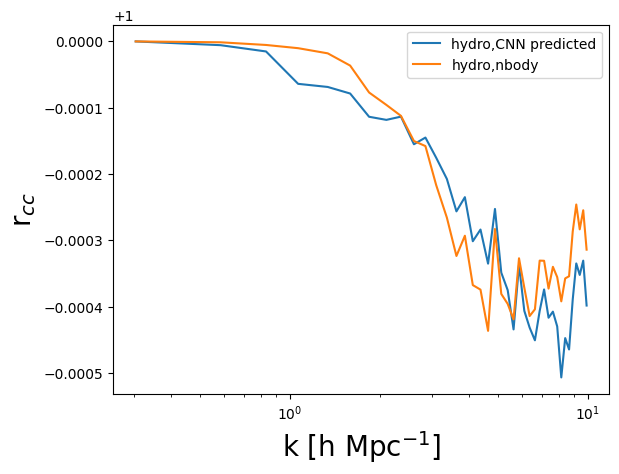

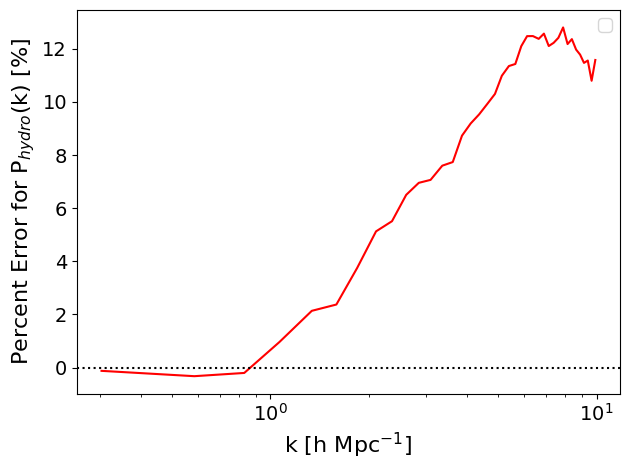

In [102]:
grid    = 256     #the map will have grid^2 pixels
BoxSize = 25 #Mpc/h
MAS     = 'None'  #MAS used to create the image; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
threads = 1       #number of openmp threads
axis = 0
verbose = False

simulations = [0,50,100]
for i in simulations:
    conditioning, params, target = dm_25_thick.test_data[i]
    residual_grid, postTF_grid = applyCNN(conditioning[np.newaxis,:], cond=True, params = params[np.newaxis,:]) #path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere
    Pk2D_hydro = PKL.Pk_plane((conditioning+target-1).detach().numpy().reshape([256,256]), BoxSize, MAS, threads, verbose)
    Pk2D_Nbody = PKL.Pk_plane((conditioning-1).detach().numpy().reshape([256,256]), BoxSize,  MAS, threads, verbose)
    Pk2D_postTF = PKL.Pk_plane((postTF_grid-1).detach().numpy().reshape([256,256]), BoxSize, MAS, threads, verbose) 
    k_Hydro   = Pk2D_hydro.k
    Pk_Hydro   = Pk2D_hydro.Pk
    k_NBody   = Pk2D_Nbody.k
    Pk_NBody   = Pk2D_Nbody.Pk
    k_postTF   = Pk2D_postTF.k
    Pk_postTF   = Pk2D_postTF.Pk
    #post-fit Cross-correlation -- more wiggly, slightly under saved Rcc from k~8
    Pkcc = PKL.XPk_plane((conditioning+target-1).detach().numpy().reshape([256,256]),(postTF_grid-1).detach().numpy().reshape([256,256]),  BoxSize, MAS,MAS, threads=1) 
    kcc   = Pkcc.k
    Pk0_X = Pkcc.r
    Pkcc = PKL.XPk_plane((conditioning+target-1).detach().numpy().reshape([256,256]),(conditioning-1).detach().numpy().reshape([256,256]),  BoxSize, MAS,MAS, threads=1) 
    kcc_true   = Pkcc.k
    Pk0_X_true = Pkcc.r
    
    plt.figure()
    mask = k_Hydro <= 10
    # Apply the mask to filter k values and P(k) values
    plt.plot(k_Hydro[mask], Pk_Hydro[mask], label='Hydro')
    plt.plot(k_NBody[mask], Pk_NBody[mask], label='NBody')
    plt.plot(k_postTF[mask], Pk_postTF[mask], label = 'Prediction')    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
    plt.ylabel(r'P(k)', fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.tight_layout()     
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.tight_layout()
    # plt.savefig('GPemu-PaperPlots/{}_{}_{}_z={}_fl_Pk.pdf'.format(sim, s, res, z))
    plt.show()
    
    plt.figure()
    plt.plot(kcc[kcc <= 10], Pk0_X[kcc <= 10],label = f'hydro,CNN predicted')
    plt.plot(kcc_true[kcc <= 10], Pk0_X_true[kcc <= 10],label = f'hydro,nbody')
    plt.xscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
    plt.ylabel(r'r$_{cc}$', fontsize=20)
    plt.legend()
    plt.show()
    
    error = 100*(Pk_Hydro-Pk_postTF)/Pk_Hydro
    plt.plot(k_NBody[mask], error[mask], color='r')
    plt.axhline(ls=':',c='k')
    plt.xscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=16)
    plt.ylabel(r'Percent Error for P$_{hydro}$(k) [%]', fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14) 
    plt.legend(fontsize='large')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_315494/2689750206.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='xx-large')


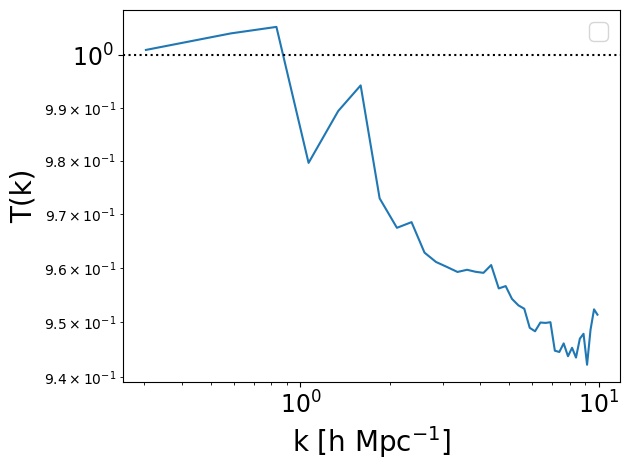

In [84]:
plt.plot(k_Hydro[mask], (Pk_postTF/Pk_Hydro)[mask])
plt.axhline(y=1, ls=':',c='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
plt.ylabel(r'T(k)', fontsize=20)
plt.legend(fontsize='xx-large')
plt.tight_layout()     
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout()
# plt.savefig('GPemu-PaperPlots/{}_{}_{}_z={}_fl_Pk.pdf'.format(sim, s, res, z))
plt.show()